# Sử dụng MLflow để Theo dõi các Kịch bản Mô phỏng Trading Edge
**Mục tiêu**

*   Tìm hiểu cách sử dụng **MLflow Tracking** để ghi lại và quản lý các thí nghiệm mô phỏng.
*   Thực hành việc log (ghi lại) các tham số đầu vào, các chỉ số kết quả (metrics), và các tạo tác (artifacts) như biểu đồ cho mỗi kịch bản mô phỏng "trading edge".

**MLflow?**
Khi thử nghiệm nhiều giả định khác nhau (ví dụ: thay đổi `sigma_model`, `market_price`, `sigma_gbm_simulation`), việc theo dõi thủ công trở nên khó khăn. MLflow giúp tự động hóa quá trình:
*   **Tái sản xuất kết quả:** Dễ dàng quay lại một lần chạy cụ thể với đúng các tham số đã dùng.
*   **So sánh các lần chạy:** Trực quan hóa sự khác biệt giữa các kịch bản.
*   **Tổ chức thí nghiệm:** Nhóm các lần chạy liên quan vào cùng một "experiment".

In [43]:
import os
import sys

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import seaborn as sns

if ".." not in sys.path:
    sys.path.append("..")

from core.option_analyzer import analyze_trading_edge

sns.set_theme(style="whitegrid")

# Config mlflow
mlflow_experiment_name = "BlackScholes_TradingEdge_Simulations_v2"
project_root_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
mlruns_directory_path = os.path.join(project_root_directory, "mlruns")
mlflow.set_tracking_uri("file:" + mlruns_directory_path)
mlflow.set_experiment(mlflow_experiment_name)

<Experiment: artifact_location='file:C:\\Users\\hoiti\\PycharmProjects\\Black_Scholes_option_lab\\mlruns/347948522746749525', creation_time=1748746925560, experiment_id='347948522746749525', last_update_time=1748746925560, lifecycle_stage='active', name='BlackScholes_TradingEdge_Simulations_v2', tags={}>

## Các kịch bản (Scenarios) Thí nghiệm

Chúng ta sẽ tạo một danh sách các kịch bản khác nhau để mô phỏng "trading edge". Mỗi kịch bản sẽ có sự khác biệt về:
*   `sigma_model_theoretical`: Độ biến động mà mô hình BS của chúng ta sử dụng để tính giá lý thuyết.
*   `market_price_transacted`: Giá mà chúng ta thực sự giao dịch quyền chọn trên thị trường.
*   `sigma_gbm_simulation`: Độ biến động thực tế của thị trường mà chúng ta dùng để mô phỏng P&L.

Các tham số chung (base parameters) sẽ được giữ cố định cho nhóm thí nghiệm này.

In [44]:
# --- Tham số cơ sở cho tất cả các kịch bản ---
base_simulation_params = {
    "S_initial": 100.0,
    "K": 100.0,
    "T": 1.0,  # Thời gian đáo hạn 1 năm
    "r": 0.05,  # Lãi suất phi rủi ro
    "option_type": "call",  # Tập trung vào Call option cho ví dụ này
    "trade_action": "buy",  # Giả sử chúng ta luôn mua Call
    "mu_gbm_simulation": 0.05,  # Giả định drift của GBM bằng r (risk-neutral)
    "num_sim_paths": 5000,  # Số lượng path mô phỏng (giảm bớt để chạy nhanh khi demo)
    "dt_gbm": 1.0 / 252.0,
    "base_random_seed": 42,  # Seed cơ sở để có thể thay đổi cho từng run
}

# --- Danh sách các kịch bản (scenarios) để chạy ---
# Mỗi dictionary trong list này sẽ ghi đè hoặc bổ sung base_simulation_params
experiment_scenarios = [
    {
        "run_name_suffix": "Ideal_PositiveEdge_MatchedVol",
        "description": "Edge dương tốt, vol mô hình khớp vol GBM, mua ở giá tốt.",
        "sigma_model_theoretical": 0.30,
        "market_price_transacted": 13.00,  # Giá Call BS(100,100,1,0.05,0.30) ~ 13.75. Edge ~0.75
        "sigma_gbm_simulation": 0.30,
    },
    {
        "run_name_suffix": "NoEdge_MatchedVol",
        "description": "Không có edge (mua đúng giá lý thuyết), vol mô hình khớp vol GBM.",
        "sigma_model_theoretical": 0.30,
        "market_price_transacted": 13.7495,  # Gần bằng giá lý thuyết BS (13.74947293)
        "sigma_gbm_simulation": 0.30,
    },
    {
        "run_name_suffix": "NegativeEdge_MatchedVol",
        "description": "Edge âm (mua đắt hơn giá lý thuyết), vol mô hình khớp vol GBM.",
        "sigma_model_theoretical": 0.30,
        "market_price_transacted": 14.50,  # Mua đắt hơn BS
        "sigma_gbm_simulation": 0.30,
    },
    {
        "run_name_suffix": "PositiveEdge_GBM_HigherVol",
        "description": "Edge dương, nhưng vol GBM thực tế CAO HƠN vol mô hình.",
        "sigma_model_theoretical": 0.25,  # Mô hình nghĩ vol thấp hơn (Giá BS ~ 10.45)
        "market_price_transacted": 10.00,  # Mua được với giá tốt theo mô hình
        "sigma_gbm_simulation": 0.30,  # Nhưng thực tế vol cao hơn
    },
    {
        "run_name_suffix": "PositiveEdge_GBM_LowerVol",
        "description": "Edge dương, và vol GBM thực tế THẤP HƠN vol mô hình (có lợi kép).",
        "sigma_model_theoretical": 0.30,  # Mô hình nghĩ vol cao (Giá BS ~ 13.75)
        "market_price_transacted": 13.00,  # Mua được với giá tốt theo mô hình
        "sigma_gbm_simulation": 0.25,  # Thực tế vol lại thấp hơn
    },
]

## Chạy các Kịch bản và Ghi lại Kết quả với MLflow

Duyệt qua từng kịch bản đã định nghĩa. Với mỗi kịch bản:
1.  Bắt đầu một "run" mới trong MLflow bằng `mlflow.start_run()`.
2.  **Log Parameters:** Ghi lại tất cả các tham số đầu vào quan trọng của mô phỏng bằng `mlflow.log_param()`.
3.  Chạy hàm `analyze_trading_edge` với các tham số của kịch bản hiện tại.
4.  **Log Metrics:** Ghi lại các chỉ số kết quả chính (P&L trung bình, edge, xác suất lãi) bằng `mlflow.log_metric()`.
5.  **Log Artifacts:** Vẽ biểu đồ phân phối P&L và lưu nó dưới dạng file ảnh, sau đó log file ảnh này vào MLflow run bằng `mlflow.log_figure()`.

Đang chạy kịch bản: Run_1_Ideal_PositiveEdge_MatchedVol


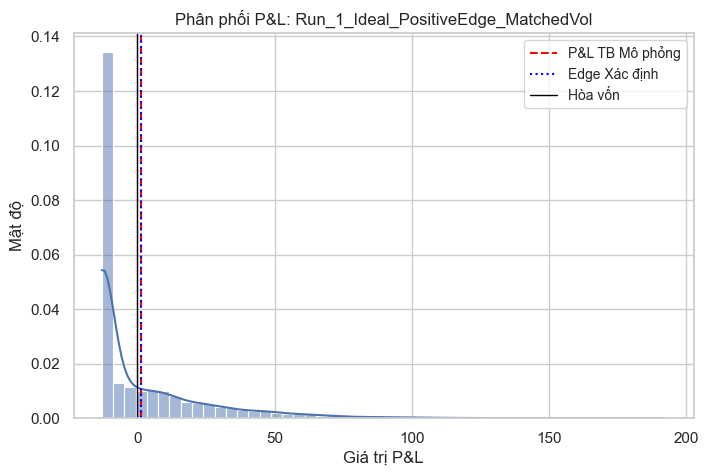

Hoàn thành và log kết quả cho: Run_1_Ideal_PositiveEdge_MatchedVol
Đang chạy kịch bản: Run_2_NoEdge_MatchedVol


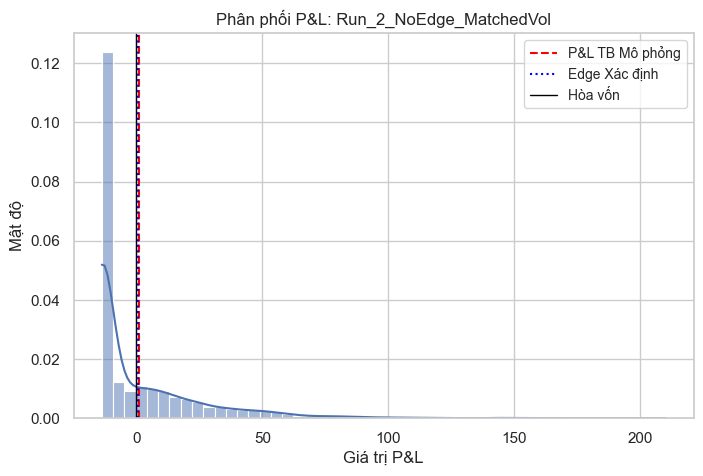

Hoàn thành và log kết quả cho: Run_2_NoEdge_MatchedVol
Đang chạy kịch bản: Run_3_NegativeEdge_MatchedVol


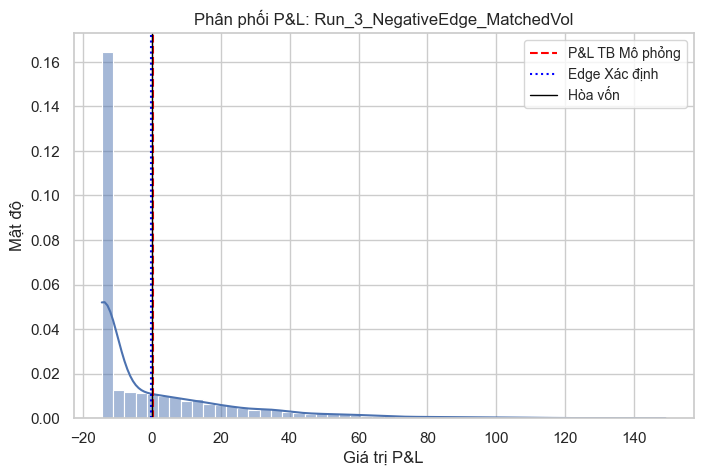

Hoàn thành và log kết quả cho: Run_3_NegativeEdge_MatchedVol
Đang chạy kịch bản: Run_4_PositiveEdge_GBM_HigherVol


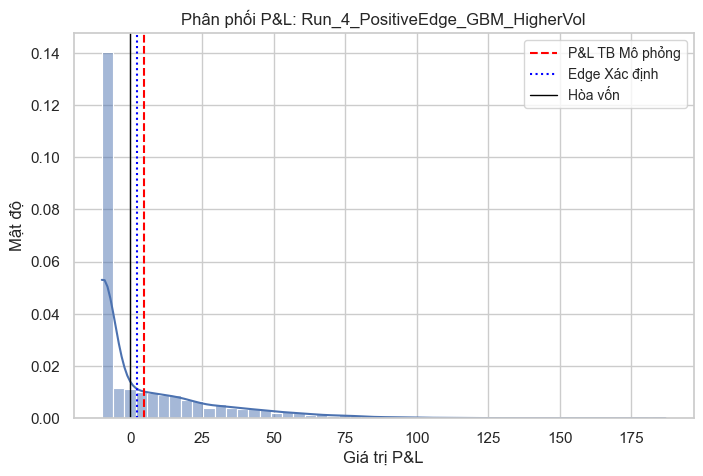

Hoàn thành và log kết quả cho: Run_4_PositiveEdge_GBM_HigherVol
Đang chạy kịch bản: Run_5_PositiveEdge_GBM_LowerVol


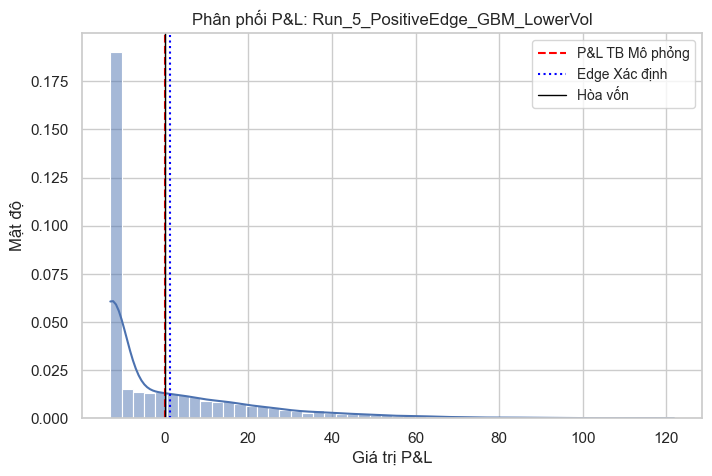

Hoàn thành và log kết quả cho: Run_5_PositiveEdge_GBM_LowerVol


In [46]:
# Vòng lặp qua từng kịch bản
for i, scenario_details in enumerate(experiment_scenarios):
    # Kết hợp tham số cơ sở với tham số của kịch bản hiện tại
    current_run_params = {**base_simulation_params, **scenario_details}

    # Tạo một random seed khác nhau cho mỗi run chính để đảm bảo các run là độc lập (nếu không ghi đè)
    current_run_params["random_seed"] = base_simulation_params["base_random_seed"] + i

    # Bắt đầu một MLflow run mới. Sử dụng 'with' để đảm bảo run được kết thúc đúng cách.
    # Đặt tên cho run để dễ nhận diện trong MLflow UI.
    run_name_for_mlflow = (
        "Run_" + str(i + 1) + "_" + scenario_details.get("run_name_suffix", "UnnamedScenario")
    )

    with mlflow.start_run(run_name=run_name_for_mlflow):
        print("Đang chạy kịch bản:", run_name_for_mlflow)

        # --- Log Parameters vào MLflow ---
        mlflow.log_param("S_initial", current_run_params["S_initial"])
        mlflow.log_param("K_strike", current_run_params["K"])
        mlflow.log_param("T_maturity", current_run_params["T"])
        mlflow.log_param("r_rate", current_run_params["r"])
        mlflow.log_param("option_type", current_run_params["option_type"])
        mlflow.log_param("trade_action", current_run_params["trade_action"])

        mlflow.log_param("sigma_model_theoretical", current_run_params["sigma_model_theoretical"])
        mlflow.log_param("market_price_transacted", current_run_params["market_price_transacted"])

        mlflow.log_param("mu_gbm_simulation", current_run_params["mu_gbm_simulation"])
        mlflow.log_param("sigma_gbm_simulation", current_run_params["sigma_gbm_simulation"])
        mlflow.log_param("num_simulation_paths", current_run_params["num_sim_paths"])
        mlflow.log_param("random_seed_used", current_run_params["random_seed"])

        # Log mô tả của kịch bản (nếu có) như một tag
        if "description" in current_run_params:
            mlflow.set_tag("mlflow.note.content", current_run_params["description"])

        # --- Chạy hàm phân tích trading edge ---
        edge_analysis_output = analyze_trading_edge(
            S_initial=current_run_params["S_initial"],
            K=current_run_params["K"],
            T=current_run_params["T"],
            r=current_run_params["r"],
            sigma_model_theoretical=current_run_params["sigma_model_theoretical"],
            market_price_transacted=current_run_params["market_price_transacted"],
            option_type=current_run_params["option_type"],
            trade_action=current_run_params["trade_action"],
            mu_gbm_simulation=current_run_params["mu_gbm_simulation"],
            sigma_gbm_simulation=current_run_params["sigma_gbm_simulation"],
            num_sim_paths=current_run_params["num_sim_paths"],
            dt_gbm=current_run_params["dt_gbm"],
            random_seed=current_run_params["random_seed"],
        )

        # --- Log Metrics vào MLflow ---
        mlflow.log_metric(
            "theoretical_bs_price", edge_analysis_output.get("theoretical_bs_price", 0)
        )
        mlflow.log_metric(
            "identified_edge_per_share", edge_analysis_output.get("identified_edge_per_share", 0)
        )
        mlflow.log_metric(
            "simulated_avg_pnl", edge_analysis_output.get("simulated_average_pnl", 0)
        )
        mlflow.log_metric(
            "simulated_std_dev_pnl", edge_analysis_output.get("simulated_std_dev_pnl", 0)
        )
        mlflow.log_metric(
            "simulated_prob_of_profit", edge_analysis_output.get("simulated_prob_of_profit", 0)
        )

        # --- Vẽ và Log Biểu đồ P&L Distribution như một Artifact ---
        pnl_dist_data = edge_analysis_output.get("pnl_distribution_simulated_array")
        if pnl_dist_data is not None and len(pnl_dist_data) > 0:
            fig, ax = plt.subplots(figsize=(8, 5))  # Tạo figure và axes mới cho mỗi run
            sns.histplot(pnl_dist_data, bins=50, kde=True, stat="density", ax=ax)
            ax.axvline(
                edge_analysis_output.get("simulated_average_pnl", 0),
                color="red",
                linestyle="dashed",
                linewidth=1.5,
                label="P&L TB Mô phỏng",
            )
            ax.axvline(
                edge_analysis_output.get("identified_edge_per_share", 0),
                color="blue",
                linestyle="dotted",
                linewidth=1.5,
                label="Edge Xác định",
            )
            ax.axvline(0, color="black", linestyle="solid", linewidth=1, label="Hòa vốn")
            ax.set_title("Phân phối P&L: " + run_name_for_mlflow)
            ax.set_xlabel("Giá trị P&L")
            ax.set_ylabel("Mật độ")
            ax.legend(fontsize="small")

            # Log biểu đồ này vào MLflow run hiện tại
            # MLflow sẽ tự lưu file ảnh và quản lý nó
            mlflow.log_figure(fig, "pnl_distribution_plot.png")
            plt.show()
            plt.close(fig)

        print("Hoàn thành và log kết quả cho:", run_name_for_mlflow)

### Trong MLflow UI:

*   **Chọn Experiment:** Ở cột bên trái, bạn sẽ thấy experiment `BlackScholes_TradingEdge_Simulations_v1` (hoặc tên bạn đã đặt). Click vào nó.
*   **Danh sách các Runs:** Bảng chính sẽ hiển thị danh sách tất cả các "run" (kịch bản) bạn vừa thực hiện.
    *   Bạn có thể thấy các cột cho "Run Name", "Start Time", và các **Metrics** (như `simulated_avg_pnl`, `identified_edge_per_share`).
    *   Click vào một "Run Name" cụ thể để xem chi tiết.
*   **Chi tiết một Run:**
    *   **Parameters:** Xem lại tất cả các tham số đầu vào đã log.
    *   **Metrics:** Xem các chỉ số kết quả. MLflow cũng có thể vẽ biểu đồ lịch sử của metric nếu bạn log nhiều giá trị cho cùng một metric qua các bước (không áp dụng ở đây nhưng hữu ích cho training ML).
    *   **Artifacts:** Đây là nơi lưu trữ các file được log. Bạn sẽ thấy file `pnl_distribution_plot.png`. Click vào nó để xem biểu đồ P&L cho run đó.
    *   **Tags:** Xem các tag, bao gồm cả mô tả bạn đã đặt trong `mlflow.note.content`.
*   **So sánh các Runs:**
    *   Quay lại danh sách các runs của experiment.
    *   Tick vào ô vuông ở đầu mỗi run mà bạn muốn so sánh.
    *   Nhấn nút **"Compare"** (thường ở phía trên bảng).
    *   MLflow sẽ hiển thị một trang so sánh, nơi bạn có thể:
        *   Xem bảng so sánh các Parameters và Metrics.
        *   Tạo các biểu đồ so sánh (ví dụ: scatter plot giữa `identified_edge_per_share` và `simulated_avg_pnl`).
